In [9]:
# pip install pandas
# pip install webcolors
# pip install seaborn

In [2]:
# confusion matrix **
# train/val random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# test random 10개 뽑아서 5장 이미지 5장 마스크 5장 이미지 5장 마스크 **
# class별 val mIoU
# easydict

import os
import random
import argparse
import cv2
import numpy as np
import pandas as pd
import webcolors
import sklearn
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision.datasets import MNIST
from torchvision import transforms
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from pycocotools.coco import COCO
import segmentation_models_pytorch as smp
from torchvision import models
from tqdm import tqdm
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from torchinfo import summary
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pytorch_lightning as pl
from transform import make_transform
from model import SmpModel
from datasets import PoseDataset
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
from torchvision import models
from torchsummary import summary

In [3]:
train_path = 'data/train'
val_path = 'data/val'
# test_path = 'test'
batch_size = 1

class_colormap = pd.DataFrame({'name': ['background',
                'body',
                'R-hand',
                'L-hand',
                'L-foot',
                'R-foot',
                'R-thigh',
                'L-thigh',
                'R-calf',
                'L-calf',
                'L-arm',
                'R-arm',
                'L-forearm',
                'R-forearm',
                'head'],
                 'r': [0, 192, 0  , 0  , 128, 64 , 64 , 192, 192, 64 , 128, 0  , 0  , 64 , 192],
                 'g': [0, 0  , 128, 128, 0  , 0  , 0  , 128, 192, 64 , 0  , 0  , 128, 128, 192],
                 'b': [0, 128, 192, 64 , 0  , 128, 192, 64 , 128, 128, 192, 128, 0  , 192, 192]})

category_names = ['background', 'body','R-hand', 'L-hand','L-foot','R-foot', 'R-thigh', 'L-thigh',  'R-calf','L-calf',  'L-arm', 'R-arm', 'L-forearm','R-forearm','head']

def collate_fn(batch):
    return tuple(zip(*batch))

########################### DataLoader define ###########################
    
def create_trash_label_colormap():
    """Creates a label colormap used in Trash segmentation.
    Returns:
        A colormap for visualizing segmentation results.
    """
    colormap = np.zeros((15, 3), dtype=np.uint8)
    for inex, (_, r, g, b) in enumerate(class_colormap.values):
        colormap[inex] = [r, g, b]
    
    return colormap

def label_to_color_image(label):

    if label.ndim != 2:
        raise ValueError('Expect 2-D input label')

    colormap = create_trash_label_colormap()

    if np.max(label) >= len(colormap):
        raise ValueError('label value too large.')

    return colormap[label]

########################### mIoU 계산 ###########################
    
def label_accuracy_score(hist):
    """
    Returns accuracy score evaluation result.
      - [acc]: overall accuracy
      - [acc_cls]: mean accuracy
      - [mean_iu]: mean IU
      - [fwavacc]: fwavacc
    """
    acc = np.diag(hist).sum() / hist.sum()
    with np.errstate(divide='ignore', invalid='ignore'):
        acc_cls = np.diag(hist) / hist.sum(axis=1)
    acc_cls = np.nanmean(acc_cls)

    with np.errstate(divide='ignore', invalid='ignore'):
        iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)

    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    return acc, acc_cls, mean_iu, fwavacc, iu

def add_hist(hist, label_trues, label_preds, n_class):
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)
    return hist

def _fast_hist(label_true, label_pred, n_class):
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist
        
def draw_confusion_matrix(cf_matrix, save_dir = 'confusion_matrix.png'):
    fig, ax = plt.subplots(figsize=(10,10))
    a=cf_matrix.astype('float')/cf_matrix.sum(axis=1)[:, np.newaxis]
    df_cm = pd.DataFrame(a, index = category_names, columns = category_names)
    sns.heatmap(df_cm.round(2), annot = True, cmap = plt.cm.Blues)
    plt.savefig(save_dir)
    
########################### mIoU추출 ###########################        

def extract_best_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU >= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]


def extract_worst_mIoU(index, now_mIoU, mIoU_list, best_img_list):
    temp_miou = []
    temp_img = []
    skip = True
    for i in range(10):
        if now_mIoU <= mIoU_list[i] and skip:
            temp_miou.append(now_mIoU)
            temp_img.append(index)
            skip = False
        temp_miou.append(mIoU_list[i])
        temp_img.append(best_img_list[i])
    return temp_miou[:10], temp_img[:10]

########################### Main 함수 ###########################

def main(model, 
         data_dir = train_path, 
         mode = 'train',
         n_class = 15,
         confusion_matrix= True, 
         save_image_pred = True, 
         mIoU_print = True):
    if mode not in ('train','val'):
        raise print('using train or val dataset')
    
    mIoU_best10 = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10 = [99,99,99,99,99,99,99,99,99,99]
    mIoU_best10_imageid = [0,0,0,0,0,0,0,0,0,0]
    mIoU_worst10_imageid = [0,0,0,0,0,0,0,0,0,0]
    
    dataset = PoseDataset(data_dir=data_dir, mode=mode, transform=A.Compose([ToTensorV2()]))
    loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)    
    
    hist = np.zeros((n_class, n_class))
    with torch.no_grad():
        for index, (data) in tqdm(enumerate(loader)):
            img_hist = np.zeros((n_class, n_class))
            temp_images, temp_masks = data
            model.eval()
            
            outs = model(torch.stack(temp_images).to(device))#['out']
            oms = torch.argmax(outs, dim=1).detach().cpu().numpy()
            masks = torch.stack(temp_masks).numpy()
            
            if mode in ('train','val') and confusion_matrix:
                if index == 0 : 
                    cf_matrix = sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(n_class)))
                else : 
                    cf_matrix += sklearn.metrics.confusion_matrix(np.ndarray.flatten(masks),
                                                  np.ndarray.flatten(oms[0]),
                                                  labels=list(range(n_class)))
                    
            if mIoU_print:
                
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                img_hist = add_hist(img_hist, masks, oms, n_class=n_class)
                hist = add_hist(hist, masks, oms, n_class=n_class)
                _, _, img_mIoU, _, _ = label_accuracy_score(img_hist)
                
                if img_mIoU > mIoU_best10[-1]: 
                    mIoU_best10,mIoU_best10_imageid = extract_best_mIoU(index,img_mIoU,mIoU_best10,mIoU_best10_imageid)
                if img_mIoU < mIoU_worst10[-1]: 
                    mIoU_worst10,mIoU_worst10_imageid = extract_worst_mIoU(index,img_mIoU,mIoU_worst10,mIoU_worst10_imageid)
                    
        if confusion_matrix:
            draw_confusion_matrix(cf_matrix,'confusion_matrix.png')

        if mIoU_print:
            _, _, mIoU, _, _ = label_accuracy_score(hist)
    
    return mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid

In [42]:
dataset = PoseDataset(data_dir='data/train', mode='train', transform=A.Compose([ToTensorV2()]))
loader = torch.utils.data.DataLoader(dataset=dataset, batch_size = 1, num_workers=4, collate_fn=collate_fn)  

In [57]:
100/4.4


22.727272727272727

In [56]:
loader.__iter__().__next__()[0][0]

tensor([[[ 27,  28,  29,  ..., 112, 139,  90],
         [ 27,  25,  25,  ..., 193, 212,  50],
         [ 29,  25,  26,  ..., 199, 168,  52],
         ...,
         [155, 165, 178,  ..., 148, 142, 144],
         [170, 152, 143,  ..., 155, 156, 152],
         [167, 163, 163,  ..., 149, 152, 147]],

        [[ 25,  25,  23,  ..., 127, 155, 111],
         [ 25,  20,  19,  ..., 210, 231,  74],
         [ 25,  20,  19,  ..., 221, 189,  77],
         ...,
         [155, 165, 176,  ..., 144, 138, 140],
         [170, 152, 141,  ..., 151, 152, 147],
         [167, 163, 161,  ..., 145, 147, 142]],

        [[ 24,  21,  18,  ..., 119, 148, 103],
         [ 24,  17,  14,  ..., 201, 222,  64],
         [ 24,  17,  16,  ..., 209, 180,  67],
         ...,
         [155, 165, 176,  ..., 143, 137, 139],
         [170, 152, 141,  ..., 150, 151, 148],
         [167, 163, 161,  ..., 144, 148, 143]]], dtype=torch.uint8)

In [40]:
model = getattr(smp, 'Unet')(
    encoder_name= "timm-tf_efficientnet_lite4", # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=15,                     # model output channels (number of classes in your dataset)
)

In [39]:
model_path = 'saved/Unet_timm-tf_efficientnet_lite4/Unet_timm-tf_efficientnet_lite4-epoch=10-val/mIoU=0.05.ckpt' 

checkpoint_callback = ModelCheckpoint(dirpath=model_path)
trainer =  pl.Trainer(gpus=1,callbacks=[checkpoint_callback])
model = model.to(device)
trainer.fit(model)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


ValueError: Expected a parent

In [37]:
model_path = 'saved/Unet_timm-tf_efficientnet_lite4/Unet_timm-tf_efficientnet_lite4-epoch=10-val/mIoU=0.05.ckpt' 
# data = torch.load(model_path)
# torch.save(data.type(torch.uint8),'deeplabv3+.pt') 
# data = torch.load('deeplabv3+.pt')

# # best model 불러오기
# checkpoint = torch.load(model_path, map_location=device)
# # state_dict = checkpoint['state_dict']
# model.load_state_dict(state_dict)

model = model.to(device)

loading annotations into memory...
Done (t=4.11s)
creating index...
index created!


2617it [03:14, 13.71it/s]


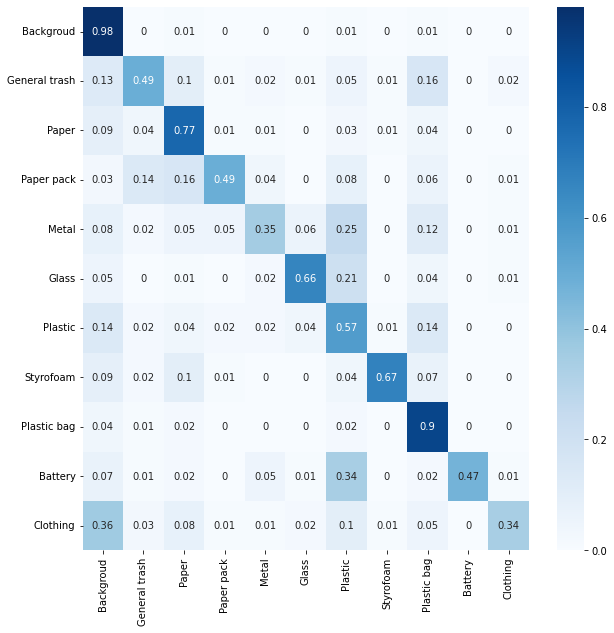

In [10]:
# parser = argparse.ArgumentParser()
# parser.add_argument('--archi', type=str, default='unet')
# parser.add_argument('--backbone', type=str, default='efficientnet-b0')
# parser.add_argument('--pretrained_weights', type=str, default='imagenet')
# args = parser.parse_args()

# model = SmpModel(args)



mIoU, mIoU_best10, mIoU_best10_imageid, mIoU_worst10, mIoU_worst10_imageid = main(model, val_path, mode = 'train')
# plot_examples(mode="val",data_dir=val_path,image_id = mIoU_best10_imageid,image_save_path = 'save_best_mIoU10')
# plot_examples(mode="val",data_dir=val_path,image_id = mIoU_worst10_imageid,image_save_path = 'save_worst_mIoU10')
# plot_examples(mode="val",data_dir=val_path,image_id = None,image_save_path = 'train_random_sample_10')
# plot_examples(mode="test",data_dir=test_path,image_id = None,image_save_path = 'test_random_sample_10')

# inputs = torch.randn(1, 3, 512, 512)
# summary(model, (inputs.shape))
# print()